# Business Sales Analysis

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import matplotlib.ticker as ticker
import sys

# Set project path
sys.path.append("../")

# Import features module
from features.plot_functions import annotate_bars, format_millions

# Set plot style and context
sns.set_context("notebook")
sns.set_style("whitegrid")

### Load the csv files


In [2]:
# Load data
path = "../data/raw"
files = [file for file in os.listdir(path) if file.endswith(".csv")]

df = pd.DataFrame()

for file in files:
    # Merge all files into one dataframe
    current_df = pd.read_csv(f"{path}/{file}", header=0)
    df = pd.concat([df, current_df])

print(f"rows, cols: {df.shape}")
df.head()

cols, rows: (186849, 6)


,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
0,295665,Macbook Pro Laptop,1,1700,12/30/19 00:01,"136 Church St, New York City, NY 10001"
1,295666,LG Washing Machine,1,600.0,12/29/19 07:03,"562 2nd St, New York City, NY 10001"
2,295667,USB-C Charging Cable,1,11.95,12/12/19 18:21,"277 Main St, New York City, NY 10001"
3,295668,27in FHD Monitor,1,149.99,12/22/19 15:13,"410 6th St, San Francisco, CA 94016"
4,295669,USB-C Charging Cable,1,11.95,12/18/19 12:38,"43 Hill St, Atlanta, GA 30301"


### Finding data anomalies


In [3]:
# Find all null values
null_values = df.isna().sum()
print(null_values)

# Find headers if exists
df[df["Order ID"] == "Order ID"].head()

Order ID            544
Product             544
Quantity Ordered    544
Price Each          544
Order Date          544
Purchase Address    544
dtype: int64


,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
254,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
705,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
1101,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
2875,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
3708,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address


### Cleaning data


In [4]:
# Drop headers if exists
df = df[df["Order ID"] != "Order ID"]

# Drop null values
df = df.dropna(how="all")

### Parse the appropriate data type


In [5]:
# Parse data types
df["Order Date"] = pd.to_datetime(df["Order Date"], format="%m/%d/%y %H:%M")
df["Quantity Ordered"] = df["Quantity Ordered"].astype("int")
df["Price Each"] = df["Price Each"].astype("float")
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 185950 entries, 0 to 13621
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Order ID          185950 non-null  object        
 1   Product           185950 non-null  object        
 2   Quantity Ordered  185950 non-null  int64         
 3   Price Each        185950 non-null  float64       
 4   Order Date        185950 non-null  datetime64[ns]
 5   Purchase Address  185950 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(3)
memory usage: 9.9+ MB


In [6]:
# Export to pickle, feather, and csv
df.to_pickle("../data/processed/sales.pickle")
df.to_csv(("../data/processed/sales.csv"), index=False)

## Exploratory Data Analysis


#### Question 1: What was the best month for sales? How much was earned that month?


In [7]:
# Add new column "Month" as text
df["Month"] = df["Order Date"].dt.strftime("%B")

# Group by month then select the price and multiply by ordered quantity
df["Total Price"] = df["Quantity Ordered"] * df["Price Each"]
highest_month_sales = df.groupby("Month")[["Total Price"]].sum().reset_index()

# Define a custom order for sorting months
month_order = [
    "January",
    "February",
    "March",
    "April",
    "May",
    "June",
    "July",
    "August",
    "September",
    "October",
    "November",
    "December",
]

# Sort the data based on the custom order
highest_month_sales["Month"] = pd.Categorical(
    highest_month_sales["Month"], categories=month_order, ordered=True
)
highest_month_sales = highest_month_sales.sort_values(by="Month")
highest_month_sales

,Month,Total Price
4,January,1822256.73
3,February,2202022.42
7,March,2807100.38
0,April,3390670.24
8,May,3152606.75
6,June,2577802.26
5,July,2647775.76
1,August,2244467.88
11,September,2097560.13
10,October,3736726.88


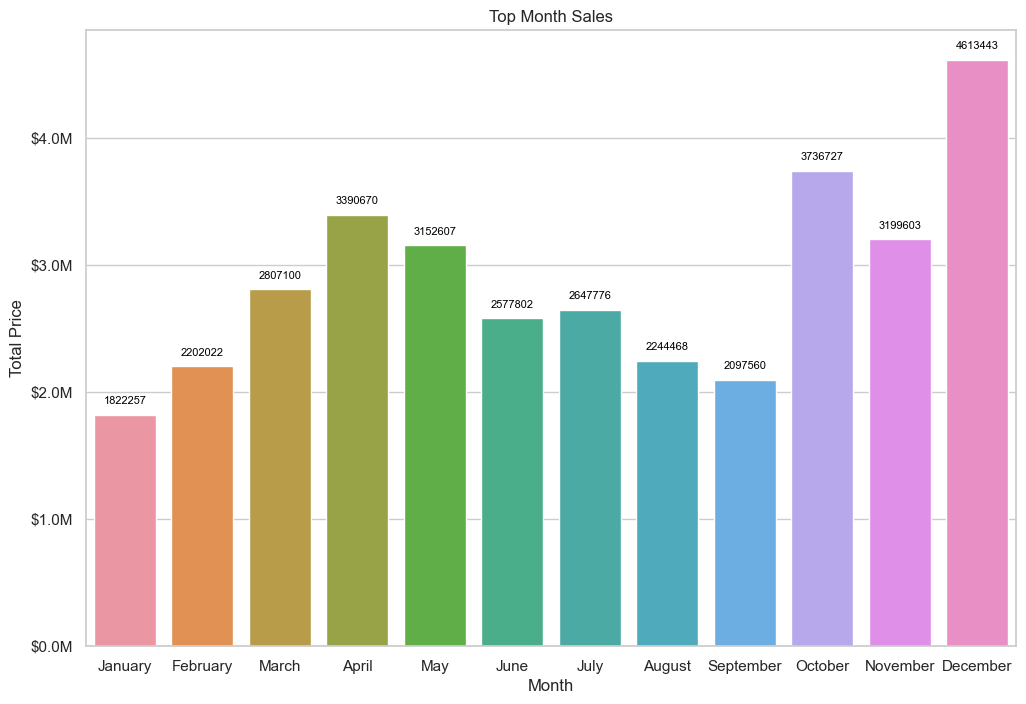

In [8]:
# Bar plot
plt.figure(figsize=(12, 8))
ax = sns.barplot(data=highest_month_sales, x="Month", y="Total Price")
plt.title("Top Month Sales")

# Set the y-axis labels to be in millions
ax.yaxis.set_major_formatter(ticker.FuncFormatter(format_millions))

# Annotate bars
annotate_bars(ax)
plt.show()

> The best month for sales was December, with a total sales revenue of $4,613,443.34.


#### Question 2: What city has the most sales?


In [9]:
# Extract the city from the Purchase Address column
df["City"] = df["Purchase Address"].str.split(", ").str[1]

# Find the top city by aggregating the total price to total sales
highest_product_city = (
    df.groupby("City")
    .agg(Total=("Total Price", np.sum))
    .sort_values(by="Total")
    .reset_index()
)
highest_product_city

,City,Total
0,Austin,1819581.75
1,Portland,2320490.61
2,Seattle,2747755.48
3,Dallas,2767975.40
4,Atlanta,2795498.58
5,Boston,3661642.01
6,New York City,4664317.43
7,Los Angeles,5452570.80
8,San Francisco,8262203.91


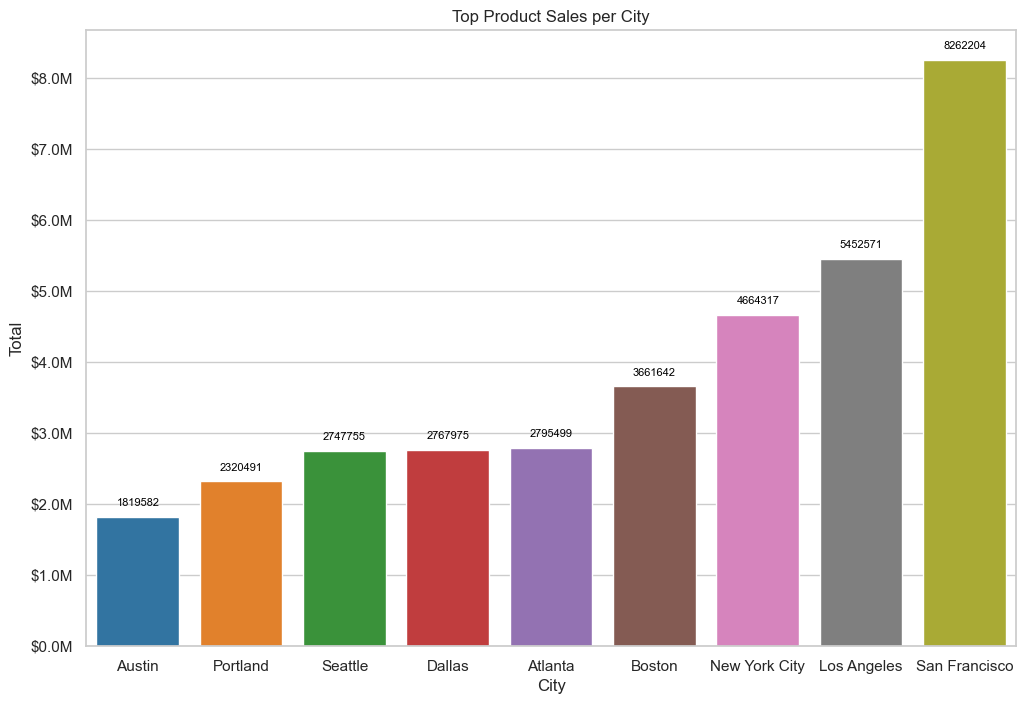

In [10]:
# Bar plot
plt.figure(figsize=(12, 8))
ax = sns.barplot(data=highest_product_city, x="City", y="Total")
plt.title("Top Product Sales per City")

# Set the y-axis labels to be in millions
ax.yaxis.set_major_formatter(ticker.FuncFormatter(format_millions))

# Annotate bars
annotate_bars(ax)
plt.show()

> The city with the most sales is San Francisco, with a total sales revenue of $8,262,203.91.


### What time should we display advertisements to maximize the likelihood of customer’s buying product?


In [11]:
# Extract hour
df["Hour"] = df["Order Date"].dt.hour

# Group and aggregate data
peek_time = df.groupby("Hour")["Quantity Ordered"].sum().reset_index()
peek_time.sort_values(by="Quantity Ordered")

,Hour,Quantity Ordered
3,3,928
4,4,937
2,2,1398
5,5,1493
1,1,2619
6,6,2810
0,0,4428
7,7,4556
8,8,7002
23,23,7065


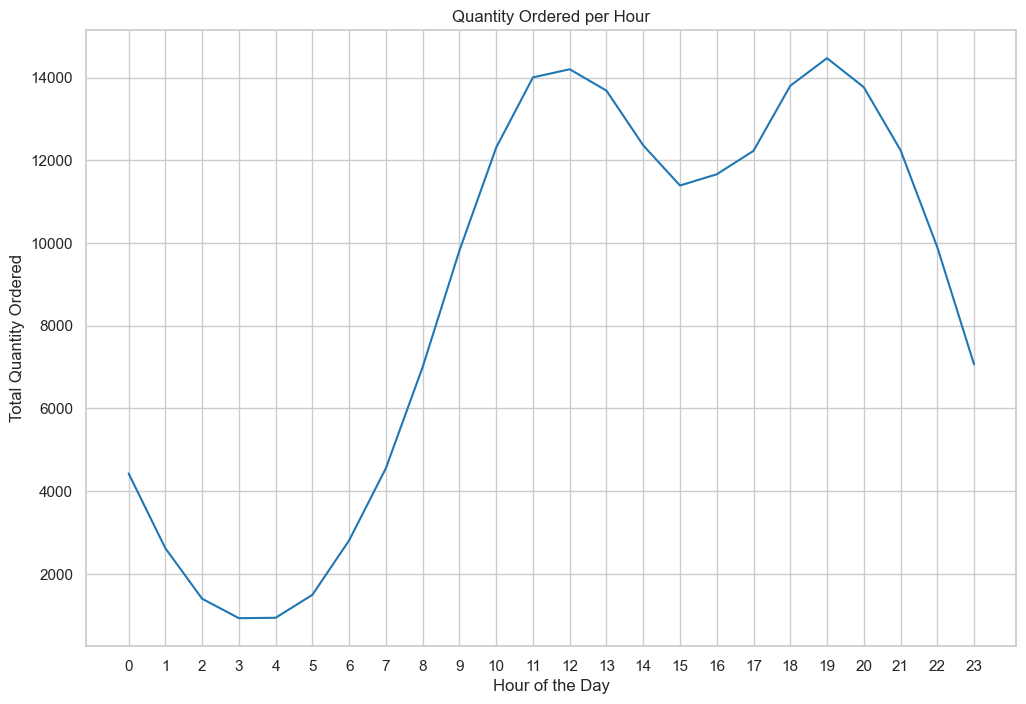

In [12]:
# Plotting
plt.figure(figsize=(12, 8))
sns.lineplot(data=peek_time, x="Hour", y="Quantity Ordered")
plt.xticks(range(24))
plt.xlabel("Hour of the Day")
plt.ylabel("Total Quantity Ordered")
plt.title("Quantity Ordered per Hour")
plt.grid(True)
plt.show()

> These ranges represent periods of the day when you can display advertisements to maximize the likelihood of customers buying products, as they have consistently high order counts:
>
> - From 11:00 AM (11) to 12:00 PM (12) with order counts ranging from 14,005 to 14,202 orders.
> - From 6:00 PM (18) to 7:00 PM (19) with order counts ranging from 13,802 to 14,470 orders.


### What product sold the most?


In [13]:
most_sold_product = (
    df.groupby(["Product", "Price Each"])
    .agg(Count=("Product", "count"))
    .reset_index()
    .sort_values(by="Count")
)
most_sold_product

,Product,Price Each,Count
10,LG Dryer,600.00,646
11,LG Washing Machine,600.00,666
16,Vareebadd Phone,400.00,2065
0,20in Monitor,109.99,4101
14,ThinkPad Laptop,999.99,4128
13,Macbook Pro Laptop,1700.00,4724
8,Flatscreen TV,300.00,4800
9,Google Phone,600.00,5525
3,34in Ultrawide Monitor,379.99,6181
1,27in 4K Gaming Monitor,389.99,6230


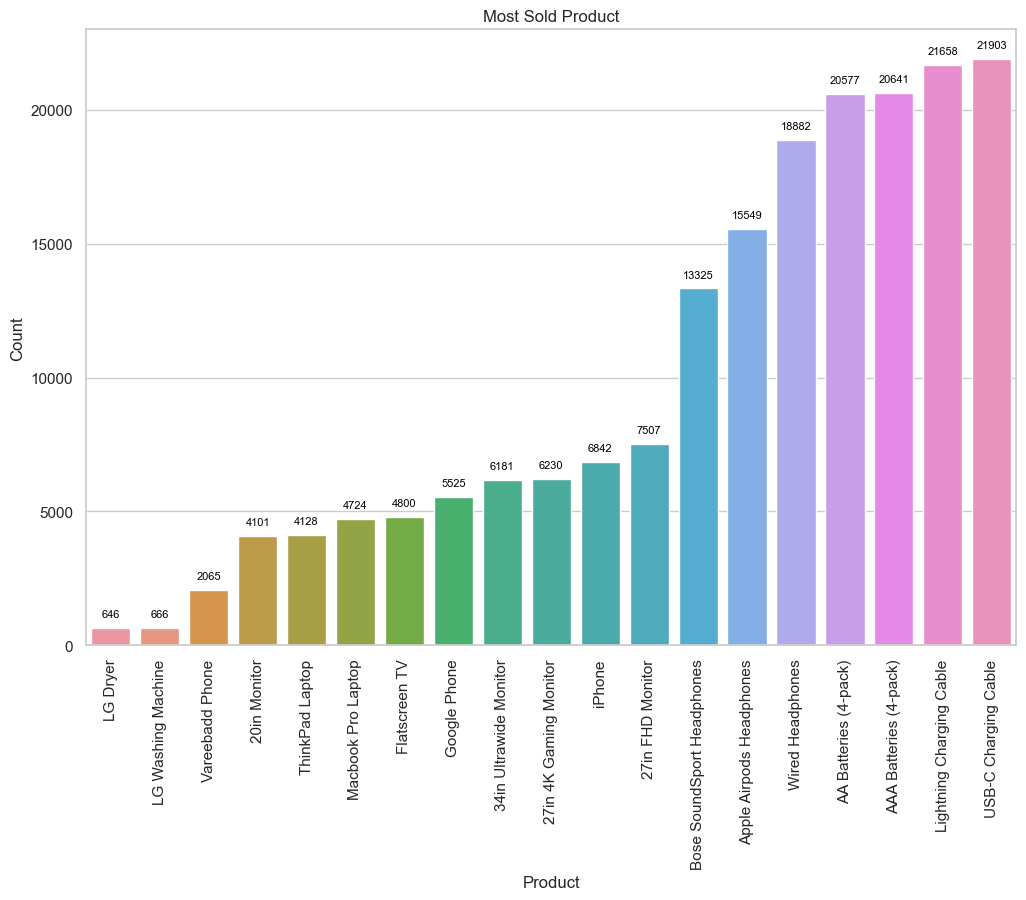

In [14]:
plt.figure(figsize=(12, 8))
ax = sns.barplot(data=most_sold_product, x="Product", y="Count")
plt.xticks(rotation=90)
plt.title("Most Sold Product")

# Annotate bars
annotate_bars(ax)
plt.show()

### Why do you think it sold the most?


In [15]:
# Find the correlation between price and count
most_sold_product["Price Each"].corr(most_sold_product["Count"])

-0.6165941267274846

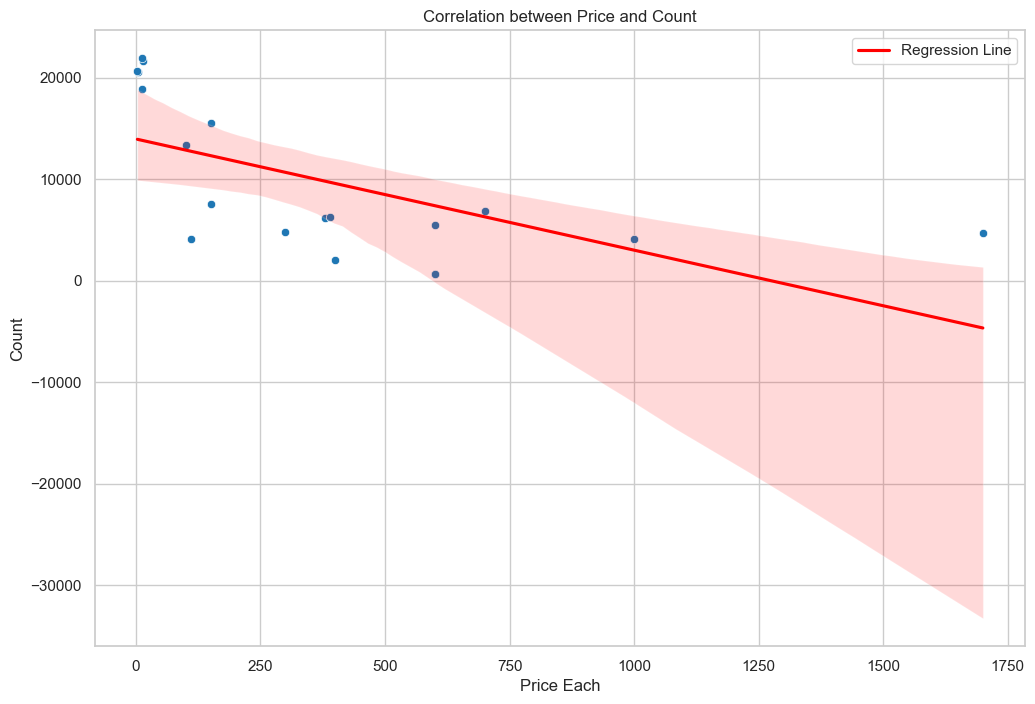

In [16]:
# Plotting
plt.figure(figsize=(12, 8))
sns.scatterplot(data=most_sold_product, x="Price Each", y="Count")
sns.regplot(
    data=most_sold_product,
    x="Price Each",
    y="Count",
    scatter=False,
    color="red",
    label="Regression Line",
)
plt.title("Correlation between Price and Count")
plt.legend()
plt.show()

> This suggests that when the product price is higher, customers are less likely to buy it in large quantities, which is a typical economic relationship in many markets. However, remember that the correlation coefficient of approximately -0.62 indicates this negative relationship, but correlation does not imply causation.


### What products are most often sold together?


In [17]:
# Find duplicate Order ID
duplicates = df[df["Order ID"].duplicated(keep=False)].sort_values(by="Order ID")
duplicates["Order ID"].value_counts()

Order ID
160873    5
263918    4
289117    4
196615    4
304802    4
         ..
200595    2
200583    2
200575    2
200568    2
319631    2
Name: count, Length: 7136, dtype: int64

In [18]:
# Merge the duplicated Order ID and concatenate the Product column
duplicates = duplicates.groupby("Order ID")["Product"].apply(", ".join).reset_index()
duplicates_count = (
    duplicates["Product"]
    .value_counts()
    .reset_index(name="Count")
    .sort_values(by="Count")
)
top_10_most_sold_together = duplicates_count.tail(10)
top_10_most_sold_together

,Product,Count
9,"Wired Headphones, Google Phone",89
8,"Google Phone, Bose SoundSport Headphones",131
7,"Lightning Charging Cable, iPhone",213
6,"USB-C Charging Cable, Google Phone",217
5,"Google Phone, Wired Headphones",222
4,"iPhone, Apple Airpods Headphones",232
3,"Vareebadd Phone, USB-C Charging Cable",250
2,"iPhone, Wired Headphones",287
1,"Google Phone, USB-C Charging Cable",651
0,"iPhone, Lightning Charging Cable",678


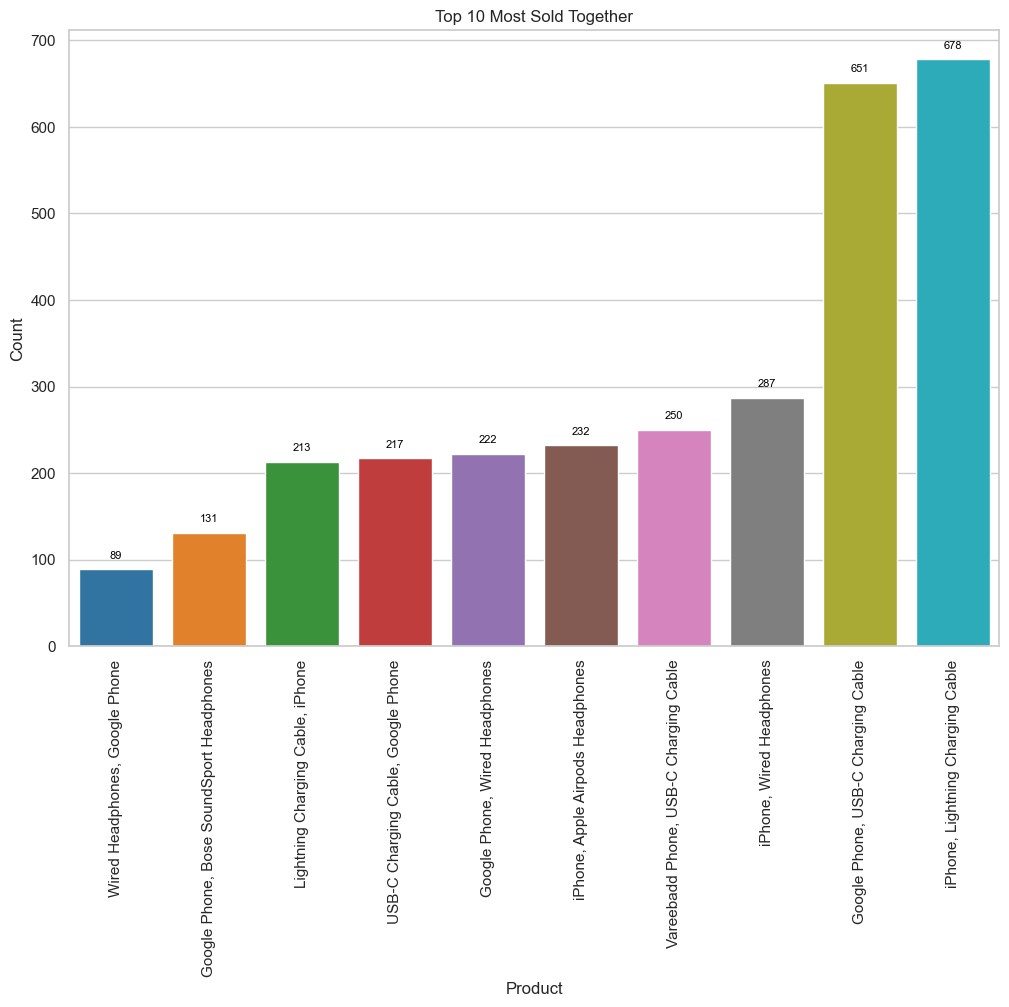

In [19]:
# Plotting
plt.figure(figsize=(12, 8))
ax = sns.barplot(data=top_10_most_sold_together, x="Product", y="Count")
plt.title("Top 10 Most Sold Together")
plt.xticks(rotation=90)

# Annotate bars
annotate_bars(ax)
plt.show()

> The data reveals that iPhone and Lightning Charging Cables are the most commonly purchased product combinations, followed closely by Google Phones and USB-C Charging Cables. This suggests that customers often buy these items together, indicating a demand for convenient smartphone charging solutions.
